In [64]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset
import h5py
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
ROOT_DIR = Path.cwd().parent
DATA_DIR = ROOT_DIR / "data"

In [52]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer("1.23", return_tensors="pt")["input_ids"].tolist()[0])
# [16, 13, 17, 18]
print(tokenizer("1 . 2 3", return_tensors="pt")["input_ids"].tolist()[0])
# [16, 659, 220, 17, 220, 18]

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 18feadcc-8ff9-4d8f-a2d0-e737b4244bb7)')' thrown while requesting HEAD https://huggingface.co/Qwen/Qwen2.5-0.5B-Instruct/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


[16, 13, 17, 18]
[16, 659, 220, 17, 220, 18]


In [53]:
with h5py.File(str(DATA_DIR / "lotka_volterra_data.h5"), "r") as f:
    # Access the full dataset
    trajectories = f["trajectories"][:]
    time_points = f["time"][:]
    
    print(f"time_points shape: {time_points.shape}, trajectories shape: {trajectories.shape}")
    
    # Access a single trajectory
    system_id = 0 # First system
    # First 50 time points:
    prey = trajectories[system_id, :50, 0]
    predator = trajectories[system_id, :50, 1]
    times = time_points[:50]

time_points shape: (100,), trajectories shape: (1000, 100, 2)


In [83]:
def normalize(data):
    mean = np.mean(data, axis=(0,1), keepdims=True)
    std = np.std(data, axis=(0,1), keepdims=True)
    return (data - mean) / std, mean, std


def encode(trajectories):
    text_data = []
    for system in trajectories:
        system_text = ";".join([f"{point[0]:.3f},{point[1]:.3f}" for point in system])
        text_data.append(system_text)
    
    return text_data

def decode(text_data):
    trajectories = []
    for system_text in text_data:
        
        points = system_text.split(";")
        system = []
        for point in points:
            try:
                prey_str, predator_str = point.split(",")
                system.append([float(prey_str), float(predator_str)])
            except ValueError:
                continue
        trajectories.append(system)
    
    trajectories = np.array(trajectories)
    
    return trajectories
    

In [55]:
normalized_trajectories, _, _ = normalize(trajectories)
texts = encode(normalized_trajectories)

In [38]:
dataset = Dataset.from_dict({"text": texts})

In [39]:
dataset

Dataset({
    features: ['text'],
    num_rows: 1000
})

In [56]:
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding=False,
        max_length=tokenizer.model_max_length,
    )

In [57]:
tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=["text"])

Map: 100%|██████████| 1000/1000 [00:00<00:00, 1727.94 examples/s]


In [58]:
# inspect the first tokenized example
tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1000
})

In [60]:
model = AutoModelForCausalLM.from_pretrained(model_name)

In [90]:
# run inference on the first example
example = tokenized_dataset[0]
print(len(example['input_ids']))
input_ids = torch.tensor(example["input_ids"])[None, :]  # Add batch dimension
attention_mask = torch.tensor(example["attention_mask"])[None, :]  # Add batch dimension


1200


In [91]:
generated_ids = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_new_tokens=1000,
)

In [92]:
print(len(texts[0]))
print(texts[0])

1297
-0.521,1.241;-0.667,0.553;-0.707,-0.014;-0.683,-0.427;-0.608,-0.710;-0.483,-0.895;-0.303,-1.010;-0.064,-1.074;0.232,-1.094;0.574,-1.074;0.935,-1.007;1.267,-0.876;1.508,-0.654;1.587,-0.312;1.447,0.159;1.085,0.685;0.594,1.085;0.129,1.174;-0.201,0.942;-0.387,0.542;-0.464,0.130;-0.466,-0.216;-0.410,-0.478;-0.304,-0.662;-0.149,-0.781;0.050,-0.844;0.287,-0.859;0.543,-0.826;0.791,-0.738;0.993,-0.586;1.103,-0.359;1.082,-0.059;0.920,0.279;0.645,0.576;0.330,0.732;0.052,0.695;-0.144,0.501;-0.255,0.231;-0.294,-0.040;-0.275,-0.272;-0.207,-0.450;-0.097,-0.576;0.049,-0.650;0.223,-0.678;0.410,-0.659;0.590,-0.593;0.735,-0.476;0.819,-0.307;0.818,-0.096;0.724,0.132;0.555,0.331;0.349,0.449;0.150,0.454;-0.008,0.352;-0.109,0.182;-0.155,-0.010;-0.152,-0.189;-0.105,-0.337;-0.023,-0.445;0.088,-0.512;0.219,-0.538;0.357,-0.525;0.487,-0.471;0.590,-0.378;0.647,-0.249;0.645,-0.095;0.581,0.064;0.467,0.199;0.325,0.279;0.184,0.287;0.066,0.224;-0.015,0.111;-0.056,-0.025;-0.057,-0.160;-0.022,-0.275;0.041,-0.363;0.1

In [93]:
decoded_output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(len(decoded_output))
print(decoded_output)

2371
-0.521,1.241;-0.667,0.553;-0.707,-0.014;-0.683,-0.427;-0.608,-0.710;-0.483,-0.895;-0.303,-1.010;-0.064,-1.074;0.232,-1.094;0.574,-1.074;0.935,-1.007;1.267,-0.876;1.508,-0.654;1.587,-0.312;1.447,0.159;1.085,0.685;0.594,1.085;0.129,1.174;-0.201,0.942;-0.387,0.542;-0.464,0.130;-0.466,-0.216;-0.410,-0.478;-0.304,-0.662;-0.149,-0.781;0.050,-0.844;0.287,-0.859;0.543,-0.826;0.791,-0.738;0.993,-0.586;1.103,-0.359;1.082,-0.059;0.920,0.279;0.645,0.576;0.330,0.732;0.052,0.695;-0.144,0.501;-0.255,0.231;-0.294,-0.040;-0.275,-0.272;-0.207,-0.450;-0.097,-0.576;0.049,-0.650;0.223,-0.678;0.410,-0.659;0.590,-0.593;0.735,-0.476;0.819,-0.307;0.818,-0.096;0.724,0.132;0.555,0.331;0.349,0.449;0.150,0.454;-0.008,0.352;-0.109,0.182;-0.155,-0.010;-0.152,-0.189;-0.105,-0.337;-0.023,-0.445;0.088,-0.512;0.219,-0.538;0.357,-0.525;0.487,-0.471;0.590,-0.378;0.647,-0.249;0.645,-0.095;0.581,0.064;0.467,0.199;0.325,0.279;0.184,0.287;0.066,0.224;-0.015,0.111;-0.056,-0.025;-0.057,-0.160;-0.022,-0.275;0.041,-0.363;0.1

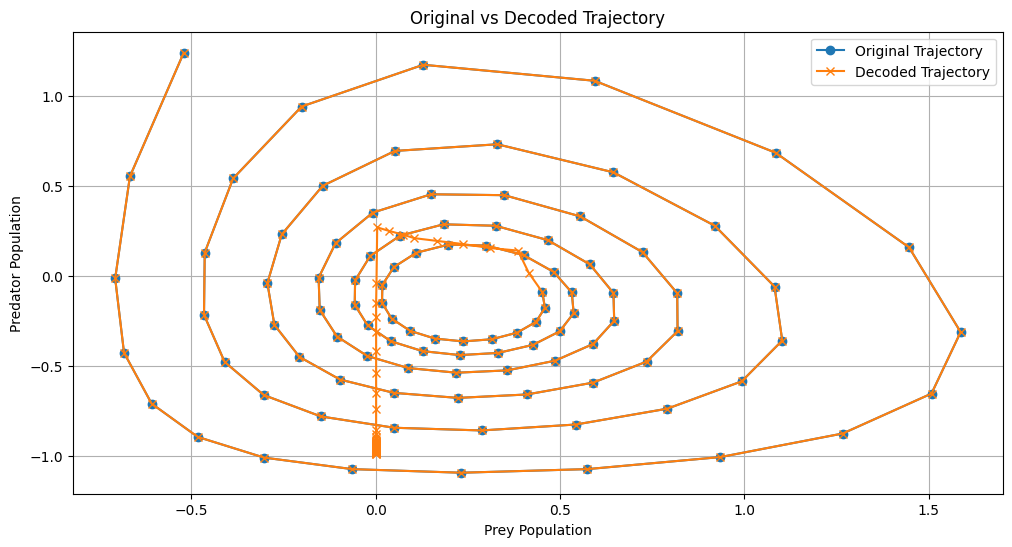

In [94]:
# plot the decoded trajectory vs the original

decoded_trajectory = decode([decoded_output])[0]  # Decode the generated text
original_trajectory = decode([texts[0]])[0]  # Decode the original text
plt.figure(figsize=(12, 6))
plt.plot(original_trajectory[:, 0], original_trajectory[:, 1], label="Original Trajectory", marker='o')
plt.plot(decoded_trajectory[:, 0], decoded_trajectory[:, 1], label="Decoded Trajectory", marker='x')
plt.xlabel("Prey Population")
plt.ylabel("Predator Population")
plt.title("Original vs Decoded Trajectory")
plt.legend()
plt.grid()
plt.show() 


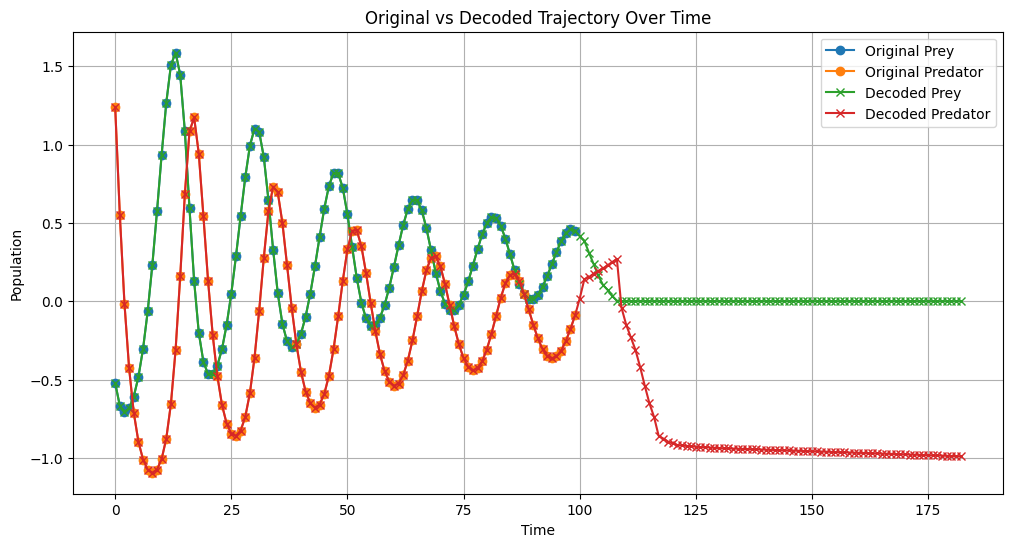

In [95]:
# plot the decoded trajectory vs the original

decoded_trajectory = decode([decoded_output])[0]  # Decode the generated text
original_trajectory = decode([texts[0]])[0]  # Decode the original text

plt.figure(figsize=(12, 6))
plt.plot(original_trajectory[:, 0], label="Original Prey", marker='o')
plt.plot(original_trajectory[:, 1], label="Original Predator", marker='o')
plt.plot(decoded_trajectory[:, 0], label="Decoded Prey", marker='x')
plt.plot(decoded_trajectory[:, 1], label="Decoded Predator", marker='x')
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Original vs Decoded Trajectory Over Time")
plt.legend()
plt.grid()
plt.show()